In [1]:
'''
Nicole Osayande
261042925
Bzdok Lab MILA
'''
import os
import aesara
import scipy as sp
import arviz as az
import numpy as np
import pymc3 as pm
import pandas as pd
import xarray as xr
import seaborn as sns
from theano import shared
import arviz.labels as azl
from scipy.stats import zscore
from theano import tensor as tt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
#investigating overall cognition and neighbourhood poverty threshold
data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/abcd_nda3_manuscript.csv', usecols=['nihtbx_totalcomp_uncorrected','reshist_addr1_adi_b138','abcd_site','site_id_l','race_ethnicity'], index_col=False)
print(data.shape)

(10843, 5)


In [3]:
val=data['reshist_addr1_adi_b138'].median()
data.loc[data['reshist_addr1_adi_b138'] <= val, 'reshist_addr1_adi_b138_bin'] = 0
data.loc[data['reshist_addr1_adi_b138'] > val, 'reshist_addr1_adi_b138_bin'] = 1

In [4]:
data['nihtbx_totalcomp_uncorrected_log']= np.log(data['nihtbx_totalcomp_uncorrected'])
col='nihtbx_totalcomp_uncorrected_log'
data['nihtbx_totalcomp_uncorrected_zscore'] = (data[col] - data[col].mean())/data[col].std(ddof=0)

In [5]:
race_idxs, race = pd.factorize(data.race_ethnicity)
data['race_enc'] = race_idxs #for shared object

state_idxs, state = pd.factorize(data.site_id_l)
data['state_enc'] = state_idxs #for shared object

In [7]:
#get input variables for shared object
abcd_race = data.race_enc.values
abcd_state = data.state_enc.values
pov = data.reshist_addr1_adi_b138_bin.values
target_values = data.nihtbx_totalcomp_uncorrected_zscore.values

In [8]:
#initialize shared objects for the model hierarchies and input variable 
abcd_race_ = shared(abcd_race)
abcd_state_ = shared(abcd_state)
pov_ = shared(pov)

In [9]:
#varying intercepts and varying slopes: 
#predicting overall cognition scores from neighbourhood poverty threshold

RANDOM_SEED = 8924
np.random.seed(286)

coords = {"abcd_race": np.arange(len(race)),"abcd_state": np.arange(len(state))}


with pm.Model(coords=coords) as varying_intercept_slope:
    
    # Hyperparameters
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5) 
   
    # Varying intercepts
    a_state = pm.Normal("a_state", mu=0.0, sigma=1.0, dims ='abcd_state')

    # Varying slopes
    b_race = pm.Normal("b_race", mu=0.0, sigma=1.0, dims ='abcd_race')
    

    # Expected value per city, theta
    # Non-centered reparameterization 
    theta = (a + a_state[abcd_state_] * sigma_a) + (b + b_race[abcd_race_] * sigma_b) * pov_
    
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    likelihood = pm.Normal("likelihood", theta, sigma=sigma, observed=target_values)
    
with varying_intercept_slope:
    varying_intercept_slope_idata = pm.sample(2000,
        tune=3000, init="adapt_diag", target_accept=0.99, random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_race, a_state, sigma_b, b, sigma_a, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 1705 seconds.
The number of effective samples is smaller than 25% for some parameters.


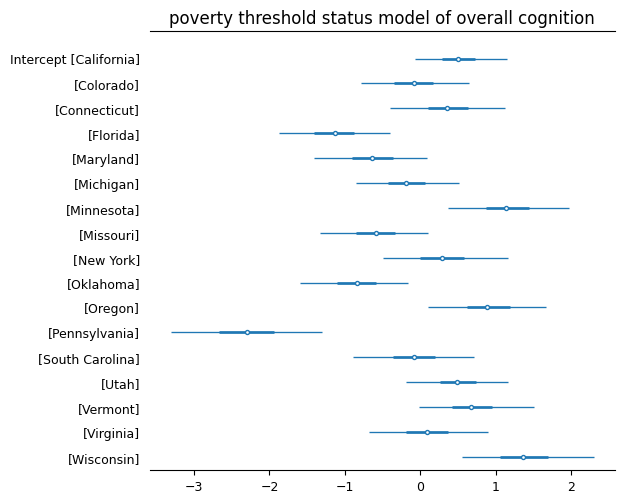

In [10]:
coords = {"abcd_state": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}
var_names = ["a_state"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"a_state": "Intercept "}
coord_map = {"abcd_state": { 0:'California', 1:'Colorado', 2:'Connecticut', 3:'Florida', 4:'Maryland',
       5:'Michigan', 6:'Minnesota', 7:'Missouri', 8:'New York', 9:'Oklahoma', 10:'Oregon',
       11:'Pennsylvania', 12:'South Carolina', 13:'Utah', 14:'Vermont', 15:'Virginia',
       16:'Wisconsin'}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes= az.plot_forest(varying_intercept_slope_idata, var_names=var_names,coords=coords,labeller=labeller,combined=True, textsize=9);
fig = axes.ravel()[0].figure
plt.title("poverty threshold status model of overall cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_plot_state_intercept_pov_thresh_overall_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_64688/2015684829.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


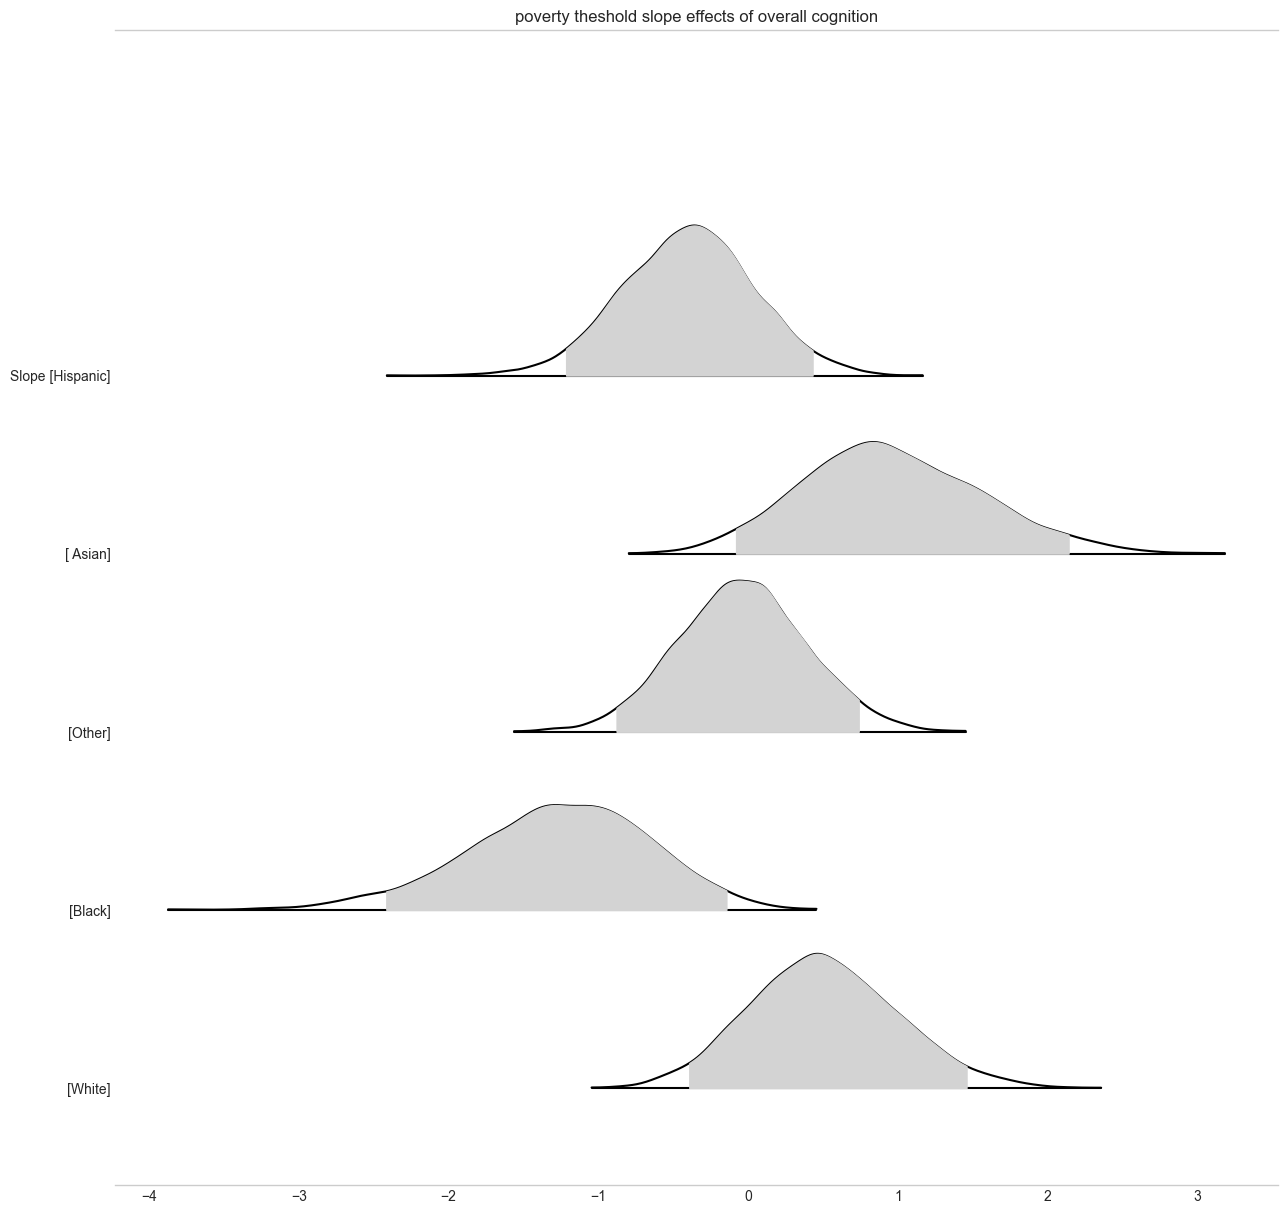

In [11]:
plt.style.use('seaborn-whitegrid')
coords = {"abcd_race": [0,1,2,3,4]}
var_names = ["b_race"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"b_race": "Slope "}
coord_map = {"abcd_race": { 0:"Hispanic", 1: " Asian", 2:"Other", 3:"Black", 4:"White"}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes = az.plot_forest(varying_intercept_slope_idata,
                           kind='ridgeplot',var_names=var_names,coords=coords,labeller=labeller,
                           combined=True,
                           ridgeplot_truncate=False,
                           ridgeplot_overlap=0.7,
                           colors='lightgrey',
                           figsize=(15, 15))
fig = axes.ravel()[0].figure
plt.title("poverty theshold slope effects of overall cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_ridge_plot_race_slope_pov_thresh_overall_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

In [12]:
with varying_intercept_slope:
    ppc = pm.sample_posterior_predictive(varying_intercept_slope_idata, var_names=["likelihood","a_state","b_race"], random_seed=RANDOM_SEED)
    

In [13]:
# Bayesian R2 score 
az.r2_score(target_values, ppc['likelihood'])

r2        0.373816
r2_std    0.003541
dtype: float64

In [14]:
#create ppc dataframe 
PP_COL = ['pp_cog_{}'.format(i) for i in range(ppc['likelihood'].shape[0])]
ppc_df = pd.DataFrame(ppc['likelihood'].T, columns=PP_COL)
ppc_df.shape

(10843, 8000)

In [16]:
# get race, state and neighbourhood poverty threshold columns for ppc dataframe, reset index for merging dataframes
abcd_race_df = pd.DataFrame(data['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df = pd.DataFrame(data['site_id_l'],columns =['site_id_l']).reset_index(drop=True)
abcd_pov_df = pd.DataFrame(data['reshist_addr1_adi_b138_bin'],columns =['reshist_addr1_adi_b138_bin']).reset_index(drop=True)


In [17]:
ppc_df = pd.merge(abcd_race_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_state_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_pov_df,ppc_df,left_index=True, right_index=True)


In [18]:
ppc_pov_race_mean = (ppc_df.groupby(['reshist_addr1_adi_b138_bin','race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_pov_race_mean

pp_cog_0  pp_cog_1  pp_cog_2  \
reshist_addr1_adi_b138_bin race_ethnicity                                 
0.0                        Asian           0.268703  0.367122  0.243908   
                           Black           0.335891  0.176752  0.239791   
                           Hispanic        0.206883  0.248207  0.240912   
                           Other           0.239971  0.208324  0.222314   
                           White           0.309704  0.272782  0.270881   
1.0                        Asian           0.410147  0.650595  0.506195   
                           Black          -0.861536 -0.875296 -0.920202   
                           Hispanic       -0.364275 -0.345444 -0.399207   
                           Other          -0.097062 -0.257099 -0.172936   
                           White           0.150380  0.096982  0.148128   

                                           pp_cog_3  pp_cog_4  pp_cog_5  \
reshist_addr1_adi_b138_bin race_ethnicity                                 
0.0                        Asian           0.173728  0.229413  0.246996   
                           Black           0.270663  0.264017  0.223808   
                           Hispanic        0.218297  0.245844  0.189160   
                           Other           0.289714  0.257670  0.144705   
                           White           0.272313  0.311074  0.259849   
1.0                        Asian           0.447710  0.234467  0.355117   
                           Black          -0.865050 -0.867378 -0.892175   
                           Hispanic       -0.328636 -0.278104 -0.396970   
                           Other          -0.169207 -0.158834 -0.105515   
                           White           0.177438  0.164306  0.168337   

                                           pp_cog_6  pp_cog_7  pp_cog_8  \
reshist_addr1_adi_b138_bin race_ethnicity                                 
0.0                        Asian           0.252752  0.295085  0.268079   
                           Black           0.285623  0.330870  0.179811   
                           Hispanic        0.256138  0.195897  0.319846   
                           Other           0.199680  0.226650  0.264462   
                           White           0.256805  0.300542  0.265641   
1.0                        Asian           0.566328  0.284961  0.610381   
                           Black          -0.892990 -0.900327 -0.892681   
                           Hispanic       -0.310305 -0.368907 -0.355443   
                           Other          -0.160540 -0.284552 -0.126755   
                           White           0.148702  0.133574  0.127825   

                                           pp_cog_9  ...  pp_cog_7990  \
reshist_addr1_adi_b138_bin race_ethnicity            ...                
0.0                        Asian           0.298300  ...     0.251318   
                           Black           0.252511  ...     0.171907   
                           Hispanic        0.249008  ...     0.267860   
                           Other           0.188678  ...     0.266024   
                           White           0.256821  ...     0.306431   
1.0                        Asian           0.568920  ...     0.391047   
                           Black          -0.859271  ...    -0.897207   
                           Hispanic       -0.367753  ...    -0.358879   
                           Other          -0.132560  ...    -0.181221   
                           White           0.143914  ...     0.171355   

                                           pp_cog_7991  pp_cog_7992  \
reshist_addr1_adi_b138_bin race_ethnicity                             
0.0                        Asian              0.252873     0.329428   
                           Black              0.166594     0.191216   
                           Hispanic           0.318339     0.292413   
                           Other              0.233221     0.232512   
                           White     

In [19]:
ppc_pov_race_mean_summ=ppc_pov_race_mean.mean(axis=1)
ppc_pov_race_mean_summ

reshist_addr1_adi_b138_bin  race_ethnicity
0.0                         Asian             0.285444
                            Black             0.219180
                            Hispanic          0.243422
                            Other             0.250773
                            White             0.273667
1.0                         Asian             0.431225
                            Black            -0.884624
                            Hispanic         -0.346170
                            Other            -0.178521
                            White             0.144667
dtype: float64

In [20]:
ppc_race_mean = (ppc_df.groupby(['race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_race_mean

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
race_ethnicity,,,,,,,,,,,,,,,,,,,,,
Asian,0.314060,0.458025,0.328017,0.261587,0.231034,0.281668,0.353308,0.291839,0.377847,0.385081,...,0.296125,0.322833,0.344798,0.249932,0.334060,0.461676,0.422959,0.349609,0.306364,0.292558
Black,-0.658436,-0.696855,-0.723451,-0.672418,-0.675478,-0.702889,-0.693081,-0.691499,-0.710772,-0.670698,...,-0.715870,-0.717570,-0.759744,-0.683248,-0.699722,-0.729254,-0.689575,-0.727341,-0.649456,-0.738835
Hispanic,-0.196565,-0.171129,-0.211247,-0.168038,-0.124256,-0.224863,-0.143979,-0.203062,-0.157156,-0.186652,...,-0.174848,-0.118707,-0.141755,-0.158134,-0.125712,-0.207618,-0.210950,-0.120473,-0.163489,-0.169746
Other,0.068922,-0.027885,0.021718,0.056804,0.046288,0.017715,0.016863,-0.032793,0.065913,0.025645,...,0.039040,0.040620,0.052203,0.035790,0.059390,-0.003663,0.016326,0.004422,0.003729,0.057503
White,0.256061,0.213592,0.229552,0.240370,0.261659,0.229038,0.220408,0.244326,0.219240,0.218807,...,0.260953,0.199703,0.231822,0.225560,0.231441,0.204375,0.204706,0.242300,0.217124,0.244157


In [21]:
ppc_race_mean_summ = ppc_race_mean.mean(axis=1)

In [22]:
ppc_pov_state_mean = (ppc_df.groupby(['reshist_addr1_adi_b138_bin','site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_pov_state_mean_summ = ppc_pov_state_mean.mean(axis=1)


In [23]:
ppc_state_mean = (ppc_df.groupby(['site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_state_mean_summ = ppc_state_mean.mean(axis=1) #for the geomaps


In [24]:
ppc_pov_state_mean_summ_list=ppc_pov_state_mean_summ.to_numpy()
low_pov_state = ppc_pov_state_mean_summ_list[:17]
high_pov_state = ppc_pov_state_mean_summ_list[-17:]

In [25]:
mean_predictions_state = [low_pov_state,high_pov_state] 
  
# Create the pandas DataFrame 
mean_pred_state = pd.DataFrame(mean_predictions_state, columns=state) 
  
# print dataframe. 
mean_pred_state

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,0.307707,0.231362,0.289773,0.096647,0.159987,0.218109,0.390252,0.164993,0.278997,0.134734,0.357151,-0.054632,0.232426,0.306342,0.330284,0.255275,0.418897
1,-0.193296,-0.124879,-0.309054,-0.435009,-0.651562,-0.259746,0.102398,-0.438827,-0.280187,-0.339738,0.095101,-0.773961,-0.358892,0.079252,0.164622,-0.282167,0.019978


In [26]:
ppc_pov_race_mean_summ_list=ppc_pov_race_mean_summ.to_numpy()
low_pov_race = ppc_pov_race_mean_summ_list[:5]
high_pov_race = ppc_pov_race_mean_summ_list[-5:]

In [27]:
# initialize list of lists 
mean_predictions_race = [low_pov_race,high_pov_race] 
  
# Create the pandas DataFrame 
mean_pred_race = pd.DataFrame(mean_predictions_race, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race

,Asian,Black,Hispanic,Other,White
0,0.285444,0.219180,0.243422,0.250773,0.273667
1,0.431225,-0.884624,-0.346170,-0.178521,0.144667


In [28]:
#auxiliary data
census_data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/census_poststrat_dataset.csv', usecols=['state','PovertyLT100_FPL_score','County_population','race_ethnicity'], index_col=False)
print(census_data.shape)

(1042, 4)


In [29]:
val = census_data['PovertyLT100_FPL_score'].median()
census_data.loc[census_data['PovertyLT100_FPL_score'] < val, 'PovertyLT100_FPL_score_bin'] = 0
census_data.loc[census_data['PovertyLT100_FPL_score'] >= val, 'PovertyLT100_FPL_score_bin'] = 1

In [30]:
census = (census_data.groupby(['state','race_ethnicity','PovertyLT100_FPL_score_bin']).County_population.agg(['sum']).reset_index())
census = census.rename(columns={'sum': 'freq'})
census

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq
0,california,Asian,0.0,767423
1,california,Asian,1.0,1067892
2,california,Black,0.0,3168044
3,california,Black,1.0,786431
4,california,Hispanic,0.0,6779394
...,...,...,...,...
136,wisconsin,Black,1.0,39628
137,wisconsin,Hispanic,0.0,88054
138,wisconsin,Other,0.0,183517
139,wisconsin,White,0.0,4001207


In [31]:
census['race_enc']=census['race_ethnicity']
census['race_enc'].replace(race,[0,1,2,3,4], inplace=True)
census['state_enc']=census['state']
census['state_enc'].replace(state,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], inplace=True)
census.head()

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,race_enc,state_enc
0,california,Asian,0.0,767423,1,0
1,california,Asian,1.0,1067892,1,0
2,california,Black,0.0,3168044,3,0
3,california,Black,1.0,786431,3,0
4,california,Hispanic,0.0,6779394,0,0


In [32]:
#fix theano shared tensor type error
census=census.astype({'PovertyLT100_FPL_score_bin':'uint8'})

In [33]:
#initialize poststrat vars
ps_abcd_race = census.race_enc.values
ps_abcd_state = census.state_enc.values
ps_pov = census.PovertyLT100_FPL_score_bin.values

#swap the model input variables 
abcd_race_.set_value(ps_abcd_race)
abcd_state_.set_value(ps_abcd_state)
pov_.set_value(ps_pov)

In [34]:
#re-run posterior predictive check with auxiliary census SDI data
with varying_intercept_slope:
    ppc2 = pm.sample_posterior_predictive(varying_intercept_slope_idata,var_names=['likelihood','a_state','b_race'],random_seed=RANDOM_SEED)
    

In [35]:
#create ppc dataframe 
PP_COL2 = ['pp_cog_{}'.format(i) for i in range(ppc2['likelihood'].shape[0])]
ppc_df2 = pd.DataFrame(ppc2['likelihood'].T, columns=PP_COL2)
ppc_df2.shape


(141, 8000)

In [36]:
censust=census
censust

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,race_enc,state_enc
0,california,Asian,0,767423,1,0
1,california,Asian,1,1067892,1,0
2,california,Black,0,3168044,3,0
3,california,Black,1,786431,3,0
4,california,Hispanic,0,6779394,0,0
...,...,...,...,...,...,...
136,wisconsin,Black,1,39628,3,16
137,wisconsin,Hispanic,0,88054,0,16
138,wisconsin,Other,0,183517,2,16
139,wisconsin,White,0,4001207,4,16


In [37]:
# get race, state, and neighbourhood poverty threshold columns for ppc dataframe, reset index for merging dataframes
abcd_race_df2 = pd.DataFrame(censust['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df2 = pd.DataFrame(censust['state'],columns =['state']).reset_index(drop=True)
abcd_pov_df2 = pd.DataFrame(censust['PovertyLT100_FPL_score_bin'],columns =['PovertyLT100_FPL_score_bin']).reset_index(drop=True)


In [38]:
ppc_df2 = pd.merge(censust['freq'],ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_pov_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_race_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_state_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,767423,-0.561898,1.532503,-0.437933,0.614290,-0.847119,-0.113351,...,1.081423,0.382447,0.612240,-0.282098,0.611813,-1.057871,-0.725979,0.992012,1.579863,0.139127
1,california,Asian,1,1067892,1.614707,0.682819,1.557624,-0.061975,0.720102,0.793534,...,-0.632641,-1.496429,-1.125012,0.535594,-0.653617,0.361031,1.608297,1.409760,0.121184,1.089138
2,california,Black,0,3168044,-1.454470,-1.802571,-0.528299,0.823197,-0.472154,1.131081,...,1.460858,0.892989,0.214842,-0.635312,0.501309,-0.802107,0.986937,-0.197836,0.523190,0.911782
3,california,Black,1,786431,-0.470883,-1.088322,-1.157949,-0.027297,-0.163719,0.126911,...,0.642515,0.367285,-0.351319,-0.925579,-2.005569,0.578301,-0.052392,-1.859323,-2.650276,-0.006743
4,california,Hispanic,0,6779394,1.226677,1.174342,-0.741108,0.107319,0.952857,0.443026,...,0.595467,0.075561,0.065369,1.211055,-0.821728,0.444927,1.995528,0.126915,0.383176,0.850002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,wisconsin,Black,1,39628,-2.260435,0.391023,0.526935,-0.199142,1.284798,1.274644,...,-1.645491,0.543511,0.154205,-0.998179,-2.371522,-0.680718,0.025879,-1.246997,-2.943126,-0.164029
137,wisconsin,Hispanic,0,88054,-0.738208,0.749363,0.665786,0.492927,0.338219,-0.202483,...,0.972219,0.069751,-0.298241,-0.193468,2.571769,0.938865,-0.080726,0.250897,0.217258,0.066223
138,wisconsin,Other,0,183517,0.773045,-0.014547,0.189841,-0.074536,0.865830,0.905440,...,0.569443,0.865930,0.590406,-0.327978,-0.415484,0.407712,0.037114,1.938399,-0.411206,-1.082814
139,wisconsin,White,0,4001207,-1.068314,1.289928,0.180387,0.759960,1.211094,0.946467,...,0.425118,-0.557306,-0.064707,0.421258,1.068604,1.432737,1.009682,0.360294,1.320962,1.295876


In [39]:
#data-weighted for each category
ppc_poststrat_df = ppc_df2.groupby(['state','race_ethnicity','PovertyLT100_FPL_score_bin']).apply(lambda df: (df[PP_COL2]*df.freq.sum(axis=0)))
ppc_poststrat_df

pp_cog_0  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0   -4.312136e+05   
                          1                          1    1.724332e+06   
           Black          0                          2   -4.607826e+06   
                          1                          3   -3.703173e+05   
           Hispanic       0                          4    8.316128e+06   
...                                                                ...   
wisconsin  Black          1                          136 -8.957651e+04   
           Hispanic       0                          137 -6.500216e+04   
           Other          0                          138  1.418669e+05   
           White          0                          139 -4.274544e+06   
                          1                          140  4.322694e+05   

                                                              pp_cog_1  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0    1.176078e+06   
                          1                          1    7.291769e+05   
           Black          0                          2   -5.710625e+06   
                          1                          3   -8.558904e+05   
           Hispanic       0                          4    7.961324e+06   
...                                                                ...   
wisconsin  Black          1                          136  1.549546e+04   
           Hispanic       0                          137  6.598438e+04   
           Other          0                          138 -2.669548e+03   
           White          0                          139  5.161269e+06   
                          1                          140  1.282909e+05   

                                                              pp_cog_2  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0   -3.360798e+05   
                          1                          1    1.663375e+06   
           Black          0                          2   -1.673676e+06   
                          1                          3   -9.106467e+05   
           Hispanic       0                          4   -5.024266e+06   
...                                                                ...   
wisconsin  Black          1                          136  2.088137e+04   
           Hispanic       0                          137  5.862516e+04   
           Other          0                          138  3.483902e+04   
           White          0                          139  7.217663e+05   
                          1                          140  1.843480e+05   

                                                              pp_cog_3  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0    4.714204e+05   
                          1                          1   -6.618217e+04   
           Black          0                          2    2.607924e+06   
                          1                          3   -2.146744e+04   
           Hispanic       0                          4    7.275568e+05   
...                                                                ...   
wisconsin  Black          1                          136 -7.891608e+03   
           Hispanic       0                          137  4.340415e+04   
           Other          0                          138 -1.367869e+04   
           White          0                          139  3.040759e+06   
                          1                          140 -7.333726e+04   

                                                              pp_cog_4  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0   -6.50

In [40]:
#re-format groupby to remove multi-index
ppc_poststrat_df = ppc_poststrat_df.to_numpy()
ppc_poststrat_df = pd.DataFrame(ppc_poststrat_df, columns=PP_COL2)
ppc_poststrat_df

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,-4.312136e+05,1.176078e+06,-3.360798e+05,4.714204e+05,-6.500988e+05,-8.698843e+04,1.987448e+05,9.029669e+05,9.731109e+05,2.233999e+04,...,8.299091e+05,2.934990e+05,4.698473e+05,-2.164882e+05,4.695194e+05,-8.118349e+05,-5.571329e+05,7.612929e+05,1.212423e+06,1.067693e+05
1,1.724332e+06,7.291769e+05,1.663375e+06,-6.618217e+04,7.689913e+05,8.474084e+05,1.566528e+06,6.500093e+05,2.096626e+06,1.563168e+06,...,-6.755926e+05,-1.598024e+06,-1.201391e+06,5.719565e+05,-6.979923e+05,3.855421e+05,1.717487e+06,1.505472e+06,1.294113e+05,1.163082e+06
2,-4.607826e+06,-5.710625e+06,-1.673676e+06,2.607924e+06,-1.495804e+06,3.583315e+06,3.863789e+06,3.476235e+06,-1.648659e+06,8.640948e+05,...,4.628061e+06,2.829030e+06,6.806281e+05,-2.012698e+06,1.588169e+06,-2.541111e+06,3.126661e+06,-6.267540e+05,1.657489e+06,2.888566e+06
3,-3.703173e+05,-8.558904e+05,-9.106467e+05,-2.146744e+04,-1.287539e+05,9.980654e+04,-1.477589e+06,-9.787485e+05,-9.908878e+05,-1.212965e+06,...,5.052940e+05,2.888443e+05,-2.762879e+05,-7.279041e+05,-1.577241e+06,4.547940e+05,-4.120242e+04,-1.462229e+06,-2.084259e+06,-5.302576e+03
4,8.316128e+06,7.961324e+06,-5.024266e+06,7.275568e+05,6.459794e+06,3.003445e+06,6.601043e+06,-2.715976e+06,8.982427e+06,-4.063607e+03,...,4.036903e+06,5.122563e+05,4.431627e+05,8.210216e+06,-5.570815e+06,3.016338e+06,1.352847e+07,8.604084e+05,2.597701e+06,5.762498e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,-8.957651e+04,1.549546e+04,2.088137e+04,-7.891608e+03,5.091396e+04,5.051161e+04,-4.693310e+04,-1.588574e+04,-1.121076e+05,-4.993733e+04,...,-6.520753e+04,2.153825e+04,6.110834e+03,-3.955582e+04,-9.397868e+04,-2.697551e+04,1.025542e+03,-4.941601e+04,-1.166302e+05,-6.500149e+03
137,-6.500216e+04,6.598438e+04,5.862516e+04,4.340415e+04,2.978152e+04,-1.782942e+04,6.650106e+04,1.224674e+05,1.948015e+04,1.663335e+05,...,8.560774e+04,6.141885e+03,-2.626134e+04,-1.703559e+04,2.264545e+05,8.267081e+04,-7.108238e+03,2.209245e+04,1.913043e+04,5.831168e+03
138,1.418669e+05,-2.669548e+03,3.483902e+04,-1.367869e+04,1.588945e+05,1.661636e+05,2.579627e+05,8.813377e+04,-1.700969e+05,3.510275e+05,...,1.045025e+05,1.589129e+05,1.083496e+05,-6.018960e+04,-7.624844e+04,7.482212e+04,6.811053e+03,3.557292e+05,-7.546335e+04,-1.987148e+05
139,-4.274544e+06,5.161269e+06,7.217663e+05,3.040759e+06,4.845838e+06,3.787009e+06,4.947071e+06,6.887197e+05,1.205248e+06,3.234743e+06,...,1.700986e+06,-2.229895e+06,-2.589077e+05,1.685539e+06,4.275706e+06,5.732677e+06,4.039948e+06,1.441612e+06,5.285443e+06,5.185069e+06


In [41]:
ppc_df2_sub = ppc_df2.iloc[:, : 4] #get the input var, race, state and freq columns, to perform another group by for the final posstratification step
ppc_df2_sub

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq
0,california,Asian,0,767423
1,california,Asian,1,1067892
2,california,Black,0,3168044
3,california,Black,1,786431
4,california,Hispanic,0,6779394
...,...,...,...,...
136,wisconsin,Black,1,39628
137,wisconsin,Hispanic,0,88054
138,wisconsin,Other,0,183517
139,wisconsin,White,0,4001207


In [42]:
ppc_poststrat_df = pd.merge(ppc_df2_sub,ppc_poststrat_df,left_index=True, right_index=True) #merge the extracted colums with the dataframe from the first step of poststratification
ppc_poststrat_df

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,767423,-4.312136e+05,1.176078e+06,-3.360798e+05,4.714204e+05,-6.500988e+05,-8.698843e+04,...,8.299091e+05,2.934990e+05,4.698473e+05,-2.164882e+05,4.695194e+05,-8.118349e+05,-5.571329e+05,7.612929e+05,1.212423e+06,1.067693e+05
1,california,Asian,1,1067892,1.724332e+06,7.291769e+05,1.663375e+06,-6.618217e+04,7.689913e+05,8.474084e+05,...,-6.755926e+05,-1.598024e+06,-1.201391e+06,5.719565e+05,-6.979923e+05,3.855421e+05,1.717487e+06,1.505472e+06,1.294113e+05,1.163082e+06
2,california,Black,0,3168044,-4.607826e+06,-5.710625e+06,-1.673676e+06,2.607924e+06,-1.495804e+06,3.583315e+06,...,4.628061e+06,2.829030e+06,6.806281e+05,-2.012698e+06,1.588169e+06,-2.541111e+06,3.126661e+06,-6.267540e+05,1.657489e+06,2.888566e+06
3,california,Black,1,786431,-3.703173e+05,-8.558904e+05,-9.106467e+05,-2.146744e+04,-1.287539e+05,9.980654e+04,...,5.052940e+05,2.888443e+05,-2.762879e+05,-7.279041e+05,-1.577241e+06,4.547940e+05,-4.120242e+04,-1.462229e+06,-2.084259e+06,-5.302576e+03
4,california,Hispanic,0,6779394,8.316128e+06,7.961324e+06,-5.024266e+06,7.275568e+05,6.459794e+06,3.003445e+06,...,4.036903e+06,5.122563e+05,4.431627e+05,8.210216e+06,-5.570815e+06,3.016338e+06,1.352847e+07,8.604084e+05,2.597701e+06,5.762498e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,wisconsin,Black,1,39628,-8.957651e+04,1.549546e+04,2.088137e+04,-7.891608e+03,5.091396e+04,5.051161e+04,...,-6.520753e+04,2.153825e+04,6.110834e+03,-3.955582e+04,-9.397868e+04,-2.697551e+04,1.025542e+03,-4.941601e+04,-1.166302e+05,-6.500149e+03
137,wisconsin,Hispanic,0,88054,-6.500216e+04,6.598438e+04,5.862516e+04,4.340415e+04,2.978152e+04,-1.782942e+04,...,8.560774e+04,6.141885e+03,-2.626134e+04,-1.703559e+04,2.264545e+05,8.267081e+04,-7.108238e+03,2.209245e+04,1.913043e+04,5.831168e+03
138,wisconsin,Other,0,183517,1.418669e+05,-2.669548e+03,3.483902e+04,-1.367869e+04,1.588945e+05,1.661636e+05,...,1.045025e+05,1.589129e+05,1.083496e+05,-6.018960e+04,-7.624844e+04,7.482212e+04,6.811053e+03,3.557292e+05,-7.546335e+04,-1.987148e+05
139,wisconsin,White,0,4001207,-4.274544e+06,5.161269e+06,7.217663e+05,3.040759e+06,4.845838e+06,3.787009e+06,...,1.700986e+06,-2.229895e+06,-2.589077e+05,1.685539e+06,4.275706e+06,5.732677e+06,4.039948e+06,1.441612e+06,5.285443e+06,5.185069e+06


In [43]:
#final step of poststratification - by race & poverty threshold 
#data-weighted average
ppc_pov_race_poststrat = ppc_poststrat_df.groupby(['PovertyLT100_FPL_score_bin','race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_pov_race_poststrat


pp_cog_0  pp_cog_1  pp_cog_2  \
PovertyLT100_FPL_score_bin race_ethnicity                                 
0                          Asian           0.510653  0.391146  0.064238   
                           Black          -0.158590 -0.060550  0.255291   
                           Hispanic        0.929163  1.169574 -0.133374   
                           Other           0.941119  0.527720  0.330409   
                           White          -0.081328  0.948383 -0.621505   
1                          Asian           0.853432 -0.014873  1.076061   
                           Black          -0.538346 -0.595759 -1.188496   
                           Hispanic        0.436373 -0.835172 -0.145497   
                           Other          -0.980158  0.525707 -0.179141   
                           White           0.146468  0.177985  0.188759   

                                           pp_cog_3  pp_cog_4  pp_cog_5  \
PovertyLT100_FPL_score_bin race_ethnicity                                 
0                          Asian           0.097461 -0.413601  0.661642   
                           Black           0.410657  0.199200  0.599794   
                           Hispanic       -0.070919  0.244001  0.315407   
                           Other          -0.165850 -0.058869 -0.711225   
                           White           0.489320 -0.088663  0.572039   
1                          Asian           0.152318  0.479020  0.483540   
                           Black          -0.646955 -0.775472 -1.186060   
                           Hispanic       -0.711049  0.025034 -0.691604   
                           Other           0.247109  0.151694  0.067558   
                           White           0.593204  0.593313  0.074448   

                                           pp_cog_6  pp_cog_7  pp_cog_8  \
PovertyLT100_FPL_score_bin race_ethnicity                                 
0                          Asian           0.957798 -0.025339 -0.257030   
                           Black           0.428762  0.251161  0.337125   
                           Hispanic        0.487628 -0.205554  0.591001   
                           Other           1.257668  0.615061 -0.203572   
                           White           0.270863  0.505755 -0.124856   
1                          Asian           1.045140  0.665156  0.638859   
                           Black          -0.953289 -0.673448 -1.065134   
                           Hispanic       -0.522054 -0.596498 -0.792831   
                           Other          -0.261841 -1.820962  0.174850   
                           White           0.304421  0.294015 -0.068652   

                                           pp_cog_9  ...  pp_cog_7990  \
PovertyLT100_FPL_score_bin race_ethnicity            ...                
0                          Asian           0.646394  ...     0.051562   
                           Black           0.431157  ...     0.379057   
                           Hispanic        0.163908  ...     0.396788   
                           Other           0.485053  ...    -0.314083   
                           White          -0.134511  ...     0.638085   
1                          Asian           0.833595  ...     0.580056   
                           Black          -0.804988  ...    -0.608638   
                           Hispanic        0.015592  ...    -1.186714   
                           Other           0.195378  ...    -0.426683   
                           White           0.116530  ...    -0.438102   

                                           pp_cog_7991  pp_cog_7992  \
PovertyLT100_FPL_score_bin race_ethnicity                             
0                          Asian              0.141087     0.252176   
                           Black             -0.012602     0.153828   
                           Hispanic           0.269795     0.219814   
                           Other              0.903605     0.139039   
                           White     

In [44]:
#summarize race & poverty threshold poststrat results
ppc_pov_race_poststrat_summ = ppc_pov_race_poststrat.mean(axis=1)
ppc_pov_race_poststrat_summ

PovertyLT100_FPL_score_bin  race_ethnicity
0                           Asian             0.200429
                            Black             0.207241
                            Hispanic          0.262539
                            Other             0.186568
                            White             0.236330
1                           Asian             0.409404
                            Black            -0.829092
                            Hispanic         -0.384203
                            Other            -0.161518
                            White             0.137220
dtype: float64

In [45]:
#final step postrat - by race
ppc_race_poststrat = ppc_poststrat_df.groupby(['race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_race_poststrat_summ = ppc_race_poststrat.mean(axis=1)
ppc_race_poststrat_summ


race_ethnicity
Asian       0.253397
Black      -0.041781
Hispanic   -0.069892
Other      -0.024073
White       0.186034
dtype: float64

In [46]:
#for the lollipops
#final step poststrat - by state & ppoverty threshold
ppc_pov_state_poststrat = ppc_poststrat_df.groupby(['PovertyLT100_FPL_score_bin','state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_pov_state_poststrat_summ = ppc_pov_state_poststrat.mean(axis=1)
ppc_pov_state_poststrat_summ

PovertyLT100_FPL_score_bin  state        
0                           california       0.315787
                            colorado         0.223983
                            connecticut      0.292865
                            florida          0.097091
                            maryland         0.153910
                            michigan         0.213840
                            minnesota        0.391765
                            missouri         0.162372
                            newyork          0.277611
                            oklahoma         0.128558
                            oregon           0.356076
                            pennsylvania    -0.052543
                            southcarolina    0.227056
                            utah             0.319767
                            vermont          0.337202
                            virginia         0.265818
                            wisconsin        0.423594
1                           california  

In [47]:
#for the geomaps
#final step poststrat - by state
ppc_state_poststrat = ppc_poststrat_df.groupby(['state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_state_poststrat_summ = ppc_state_poststrat.mean(axis=1)
ppc_state_poststrat_summ

state
california       0.190597
colorado         0.178380
connecticut      0.292865
florida         -0.147054
maryland         0.012049
michigan         0.130516
minnesota        0.358476
missouri         0.015257
newyork          0.074202
oklahoma        -0.041318
oregon           0.239969
pennsylvania    -0.097967
southcarolina   -0.031647
utah             0.283405
vermont          0.323947
virginia         0.190195
wisconsin        0.437119
dtype: float64

In [48]:
ppc_pov_state_poststrat_summ_list=ppc_pov_state_poststrat_summ.tolist()

In [49]:
#fill in missing value for connecticut
ppc_pov_state_poststrat_summ_list.insert(19,ppc_pov_state_mean_summ.iloc[19])

In [50]:
ppc_pov_state_poststrat_summ_list

[0.31578675901857356,
 0.22398271865321273,
 0.292864809554351,
 0.09709094514061724,
 0.1539100522753182,
 0.2138401886847786,
 0.39176530383092756,
 0.16237191600714318,
 0.27761071489181255,
 0.1285582377880086,
 0.3560756401531446,
 -0.05254288995157657,
 0.2270556425066795,
 0.31976691830356707,
 0.33720161781099167,
 0.2658179420922494,
 0.423594065059488,
 0.09530684630290062,
 -0.18119384523070636,
 -0.309053762825872,
 -0.37365803638477313,
 -0.823099110743334,
 0.05417248622565233,
 0.21458617244991796,
 -0.10220742677769878,
 -0.1015219484997343,
 -0.0864757355735058,
 0.16742531532880017,
 -0.20754411475098355,
 -0.15517359637210812,
 -0.06970217729884856,
 0.22588694635841045,
 0.00797942196000878,
 0.48635126177404936]

In [51]:
low_pov_state_poststrat = ppc_pov_state_poststrat_summ_list[:17]
high_pov_state_poststrat = ppc_pov_state_poststrat_summ_list[-17:]

In [52]:
ppc_pov_race_poststrat_summ_list=ppc_pov_race_poststrat_summ.tolist()

In [53]:
low_pov_race_poststrat = ppc_pov_race_poststrat_summ_list[:5]
high_pov_race_poststrat = ppc_pov_race_poststrat_summ_list[-5:]

In [54]:
mean_predictions_state_ps = [low_pov_state_poststrat,high_pov_state_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_state_ps = pd.DataFrame(mean_predictions_state_ps, columns=state) 
  
# print dataframe. 
mean_pred_state_ps

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,0.315787,0.223983,0.292865,0.097091,0.153910,0.213840,0.391765,0.162372,0.277611,0.128558,0.356076,-0.052543,0.227056,0.319767,0.337202,0.265818,0.423594
1,0.095307,-0.181194,-0.309054,-0.373658,-0.823099,0.054172,0.214586,-0.102207,-0.101522,-0.086476,0.167425,-0.207544,-0.155174,-0.069702,0.225887,0.007979,0.486351


In [55]:
# initialize list of lists 
mean_predictions_race_ps = [low_pov_race_poststrat,high_pov_race_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_race_ps = pd.DataFrame(mean_predictions_race_ps, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race_ps

,Asian,Black,Hispanic,Other,White
0,0.200429,0.207241,0.262539,0.186568,0.23633
1,0.409404,-0.829092,-0.384203,-0.161518,0.13722


In [56]:
quantiles = [0.5]

# Calculate quantiles for each row (state)
quantiles_per_state = np.quantile(ppc_state_mean, quantiles, axis=1)
quantiles_per_state_ps = np.quantile(ppc_state_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_state = quantiles_per_state.flatten().tolist()
quantiles_state_ps = quantiles_per_state_ps.flatten().tolist()

quantiles_state,quantiles_state_ps

([0.016932559948558613,
  0.13078262794911216,
  0.06917925832933289,
  -0.3090428244644952,
  -0.15921016709137695,
  -0.005744828270207265,
  0.31779052270837554,
  -0.15186275163813062,
  0.008202082286764879,
  -0.1461604796873458,
  0.2037767548290353,
  -0.6508232019989961,
  -0.06692729263858307,
  0.21759656474141562,
  0.2817547055827665,
  -0.0069914850662771985,
  0.2972026870412563],
 [0.19272538239793116,
  0.17546412736806782,
  0.2841917760161007,
  -0.1473256117226055,
  0.01056237500721045,
  0.12724100009931938,
  0.3501809491936626,
  0.013094737484820335,
  0.07081365151667365,
  -0.04507763008712752,
  0.23223693651588506,
  -0.09349437042317185,
  -0.027360323274434887,
  0.2876773462984828,
  0.32699218418695675,
  0.1849522302683294,
  0.43808200032579503])

In [57]:
capitalized_states=['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']

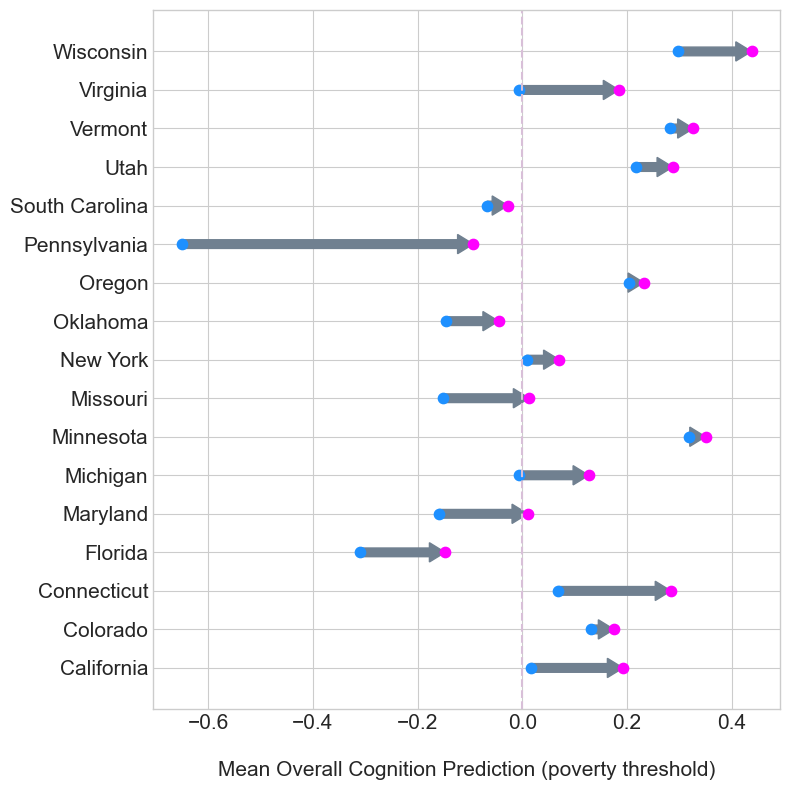

In [58]:
states = capitalized_states
quartiles_before_ps = quantiles_state   # mean prediction before poststratification
quartiles_after_ps = quantiles_state_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(8, 8))

# Plot arrows indicating change from before to after poststratification
for i in range(len(states)):
    plt.arrow(quartiles_before_ps[i], i, quartiles_after_ps[i] - quartiles_before_ps[i], 0, color='slategrey', width=0.225, head_width=0.5, head_length=0.03, length_includes_head=True)

# Plot second quartiles before poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_before_ps[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=55)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_after_ps[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=55)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(states)), states,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Overall Cognition Prediction (poverty threshold)',size=15,labelpad=20)
#plt.title('Mean Predictions of Overall Cognition based on Poverty Threshold Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_pov_thresh_overall_ps_state_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

In [59]:
quantiles_per_race = np.quantile(ppc_race_mean, quantiles, axis=1)
quantiles_per_race_ps = np.quantile(ppc_race_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_race = quantiles_per_race.flatten().tolist()
quantiles_race_ps = quantiles_per_race_ps.flatten().tolist()

quantiles_race,quantiles_race_ps

([0.3318222562803803,
  -0.697565404888963,
  -0.17306386298908844,
  0.03287359941397219,
  0.23029826679179416],
 [0.25371801317726506,
  -0.04598849195935849,
  -0.07159586418425692,
  -0.01966287178646024,
  0.18729109318561538])

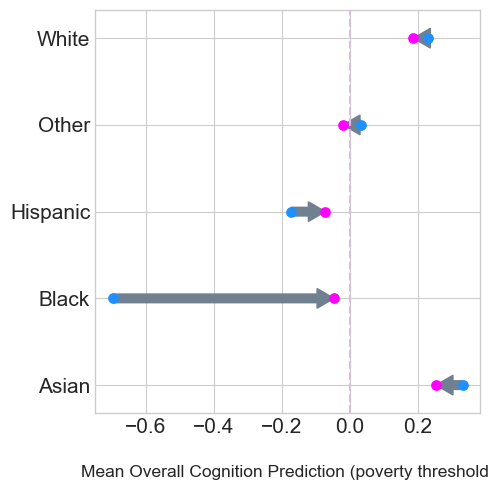

In [60]:
races = ['Asian','Black','Hispanic','Other','White']
quartiles_before_ps_r = quantiles_race   # mean prediction before poststratification
quartiles_after_ps_r = quantiles_race_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(5, 5))

# Plot arrows indicating change from before to after poststratification
for i in range(len(races)):
    plt.arrow(quartiles_before_ps_r[i], i, quartiles_after_ps_r[i] - quartiles_before_ps_r[i], 0, color='slategrey', width=0.10, head_width=0.227, head_length=0.05, length_includes_head=True)

# Plot second quartiles before poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_before_ps_r[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=45)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_after_ps_r[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=45)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(races)), races,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Overall Cognition Prediction (poverty threshold)',size=12.5,labelpad=20)
#plt.title('Mean Predictions of Overall Cognition based on Poverty Threshold Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_pov_thresh_overall_ps_race_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_64688/2996064629.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values, [state_name, state_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_64688/2996064629.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values2, [state_name2, state_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


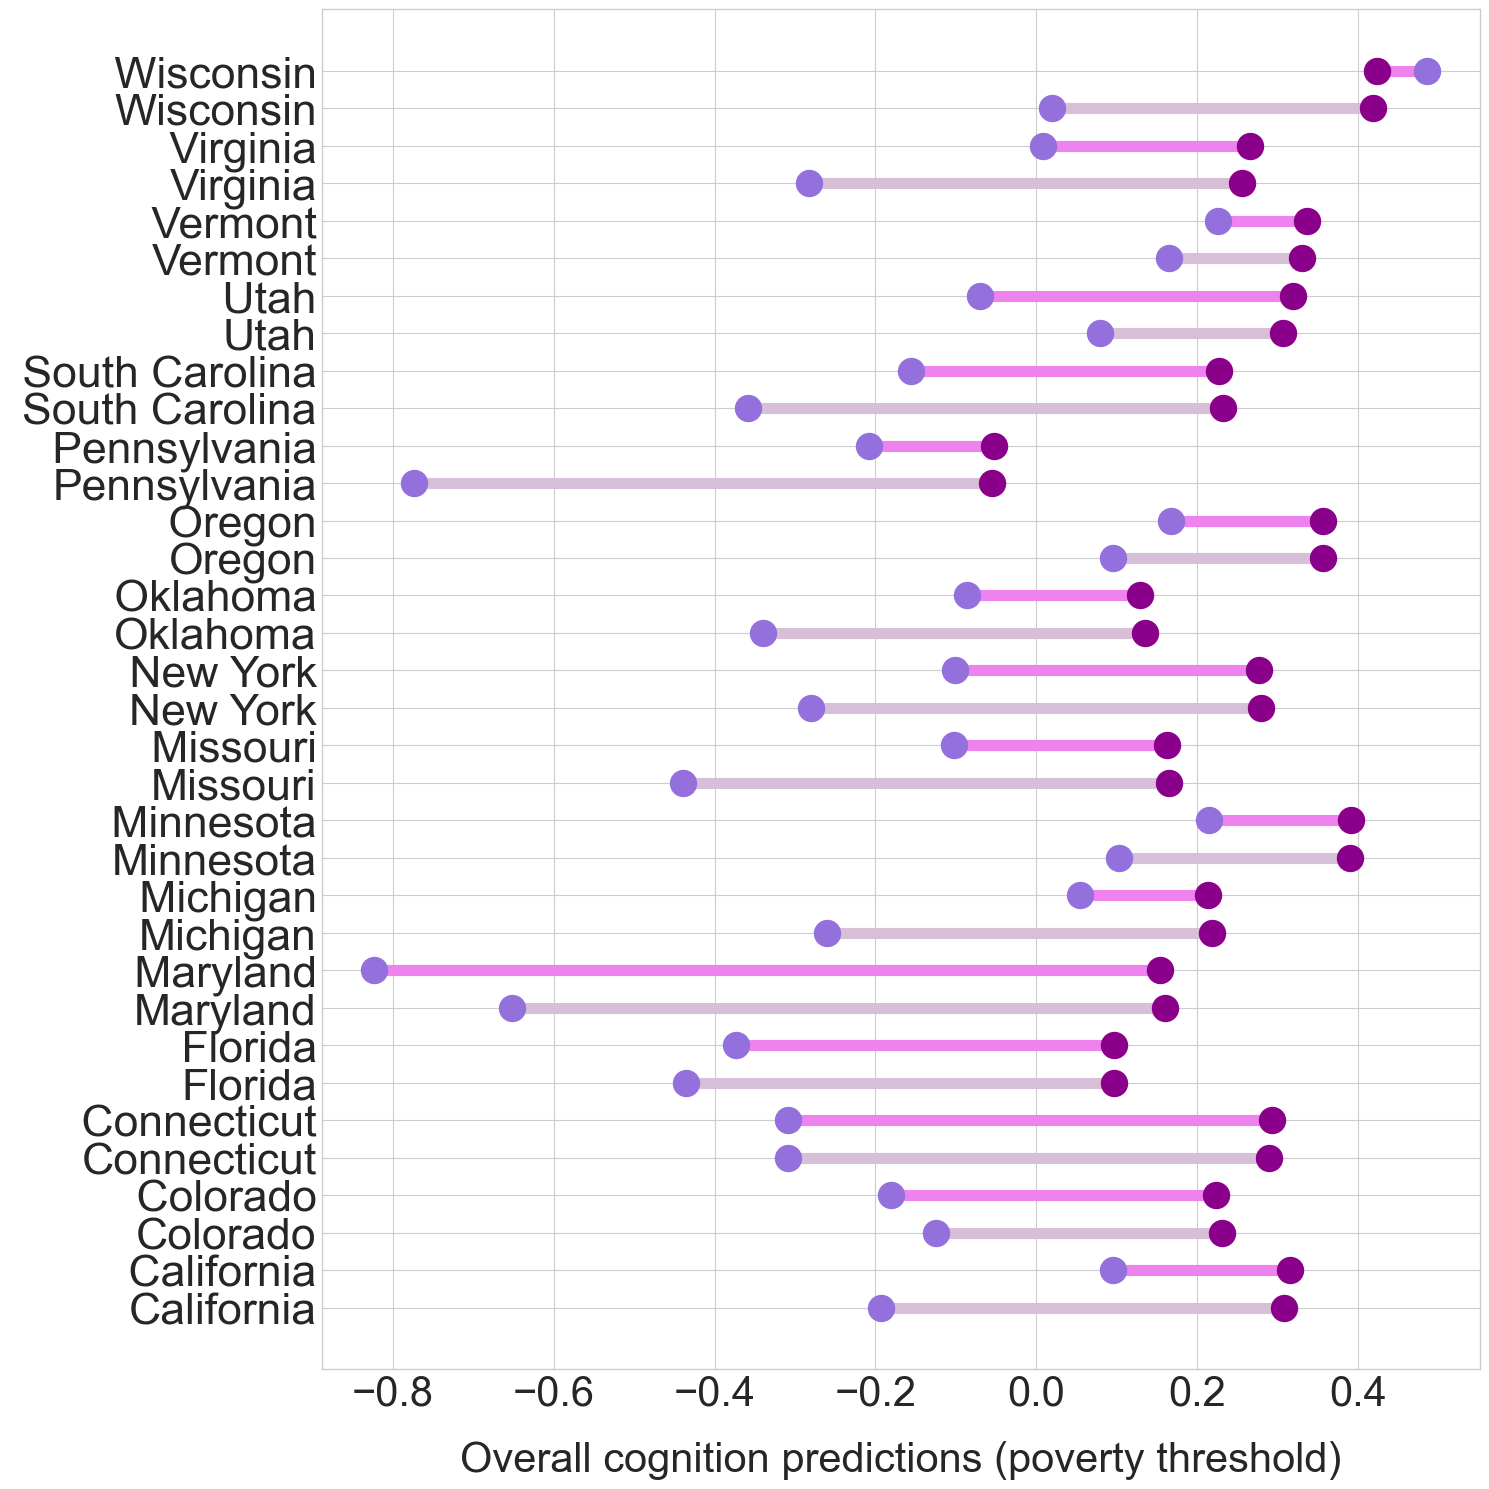

In [61]:
datas=mean_predictions_state
datas2=mean_predictions_state_ps
state_names = ['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']
state_names2 = [' California',
 ' Colorado',
 ' Connecticut',
 ' Florida',
 ' Maryland',
 ' Michigan',
 ' Minnesota',
 ' Missouri',
 ' New York',
 ' Oklahoma',
 ' Oregon',
 ' Pennsylvania',
 ' South Carolina',
 ' Utah',
 ' Vermont',
 ' Virginia',
 ' Wisconsin']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for state_name, state_values,state_name2, state_values2 in zip(state_names, np.array(datas).T,state_names2, np.array(datas2).T):
    plt.plot(state_values, [state_name, state_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(state_values2, [state_name2, state_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(state_values[0], state_name, color='darkmagenta', label='low pov oc', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values[1], state_name, color='mediumpurple', label='high pov oc', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(state_values2[0], state_name2, color='darkmagenta', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values2[1], state_name2, color='mediumpurple', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Overall cognition predictions (poverty threshold)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each State')
#plt.legend(['before PS','after PS','low pov oc', 'high pov oc'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_pov_thresh_overall_ps_state_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()


/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_64688/25792206.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values, [race_name, race_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_64688/25792206.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values2, [race_name2, race_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


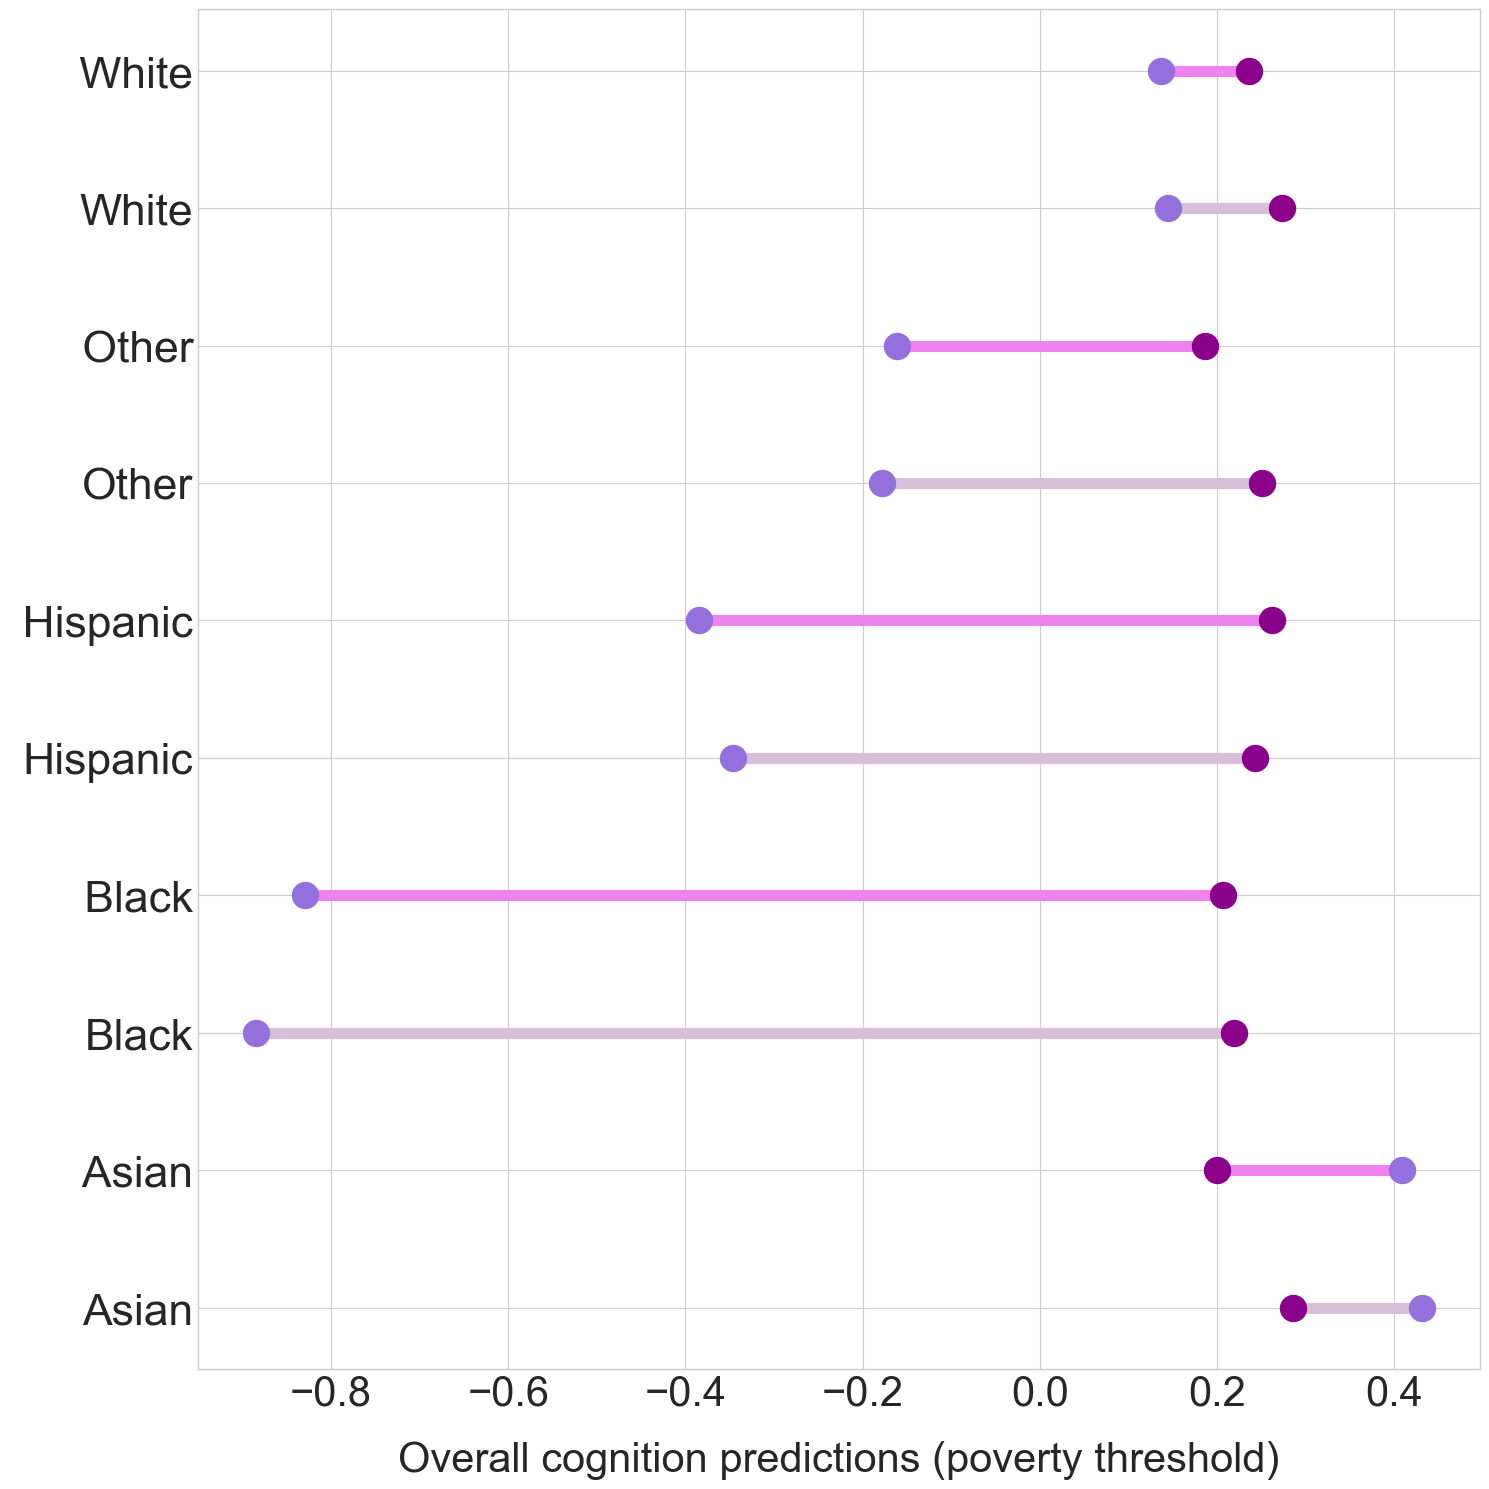

In [62]:
datas_r=mean_predictions_race
datas_r2=mean_predictions_race_ps
race_names = ['Asian',
 'Black',
 'Hispanic',
 'Other',
 'White']
#dont forget the blank space in front of the name so not overwritten
race_names2 = [' Asian',
 ' Black',
 ' Hispanic',
 ' Other',
 ' White']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for race_name, race_values,race_name2, race_values2 in zip(race_names, np.array(datas_r).T,race_names2, np.array(datas_r2).T):
    plt.plot(race_values, [race_name, race_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(race_values2, [race_name2, race_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(race_values[0], race_name, color='darkmagenta', label='low pov oc', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values[1], race_name, color='mediumpurple', label='high pov oc', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(race_values2[0], race_name2, color='darkmagenta', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values2[1], race_name2, color='mediumpurple', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Overall cognition predictions (poverty threshold)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each Race')
#plt.legend(['before PS','after PS','low pov oc', 'high pov oc'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_pov_thresh_overall_ps_race_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()